In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Carregamento arquivo de pré-processamento

In [2]:
%run "/content/drive/My Drive/Colab Notebooks/pre_processamento_TCC.ipynb"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
CPU times: user 1min 45s, sys: 11 s, total: 1min 56s
Wall time: 2min 7s
Ataque de exploração UDPLag:  Label
BENIGN       3705
UDP-lag    366461
dtype: int64 

Ataque de exploração Syn:  Label
BENIGN        392
Syn       1582289
dtype: int64 

Ataque de exploração LDAP:  Label
BENIGN           1612
DrDoS_LDAP    2179930
dtype: int64 

Ataque de exploração NetBIOS:  Label
BENIGN              1707
DrDoS_NetBIOS    4093279
dtype: int64
Ataque de exploração UDPLag:  Label
0      3705
1    366461
dtype: int64 

Ataque de exploração Syn:  Label
0        392
1    1582289
dtype: int64 

Ataque de exploração LDAP:  Label
0       1612
1    2179930
dtype: int64 

Ataque de exploração NetBIOS:  Label
0       1707
1    4093279
dtype: int64


In [3]:
LDAP = LDAP.sample(333763)
print(LDAP.groupby(by=' Label').size())

 Label
0       239
1    333524
dtype: int64


### Bibliotecas


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

### Divisão do conjunto em treino e teste


In [5]:
LDAP

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2013275,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2000000.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2000000.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,-2,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
657336,2,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,1.472000e+09,1000000.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,28,0,1000000.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,28,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1413771,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2000000.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2000000.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
718728,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2000000.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2000000.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,-2,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
793985,2,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,1.472000e+09,1000000.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,1000000.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,40,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952575,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2000000.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2000000.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1854382,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2000000.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2000000.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,40,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
174754,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2000000.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,246,0,2000000.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1

Preparação dos dados treino e teste


In [6]:
X = LDAP.iloc[:, 0:77]
y = LDAP.iloc[:,- 1]

70% para treino, 30% para teste

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3,
                                                    random_state=42)

In [8]:
# Formato dos dados de entrada
print('Formato dos dados de entrada:', x_train.shape)

# Tamanho dos conjuntos
print('Amostras de treino: ', x_train.shape[0])
print('Amostras de teste: ', x_test.shape[0])

Formato dos dados de entrada: (233634, 77)
Amostras de treino:  233634
Amostras de teste:  100129


### Seleção dos Parâmetro
Seleção dos 15 melhores parâmetros.

In [9]:
best_features = SelectKBest(score_func=f_classif, k=15)
fit = best_features.fit(x_train,y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(x_train.columns)
# concatenar quadros de dados
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  # colunas de saída de nome
print(feature_scores.nlargest(15,'Score'))  # imprima 15 melhores parâmetros

               Feature_Name          Score
47           URG Flag Count  182700.233204
50            Down/Up Ratio  157248.123232
37        Min Packet Length  136413.218019
6     Fwd Packet Length Min  136373.282311
7    Fwd Packet Length Mean  133318.242770
52     Avg Fwd Segment Size  133318.242770
39       Packet Length Mean  132019.762332
51      Average Packet Size  125996.461340
5     Fwd Packet Length Max  125533.727198
38        Max Packet Length  118011.435619
10    Bwd Packet Length Min   86022.100748
11   Bwd Packet Length Mean   47707.968548
53     Avg Bwd Segment Size   47707.968548
65   Init_Win_bytes_forward   45692.236639
29            Fwd PSH Flags   42061.799223


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [30 31 32 42 45 49 55 56 57 58 59 60 69 70 71 72 73 74 75 76] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [10]:
feature = feature_scores.nlargest(15,'Score')
feature

,Feature_Name,Score
47,URG Flag Count,182700.233204
50,Down/Up Ratio,157248.123232
37,Min Packet Length,136413.218019
6,Fwd Packet Length Min,136373.282311
7,Fwd Packet Length Mean,133318.242770
52,Avg Fwd Segment Size,133318.242770
39,Packet Length Mean,132019.762332
51,Average Packet Size,125996.461340
5,Fwd Packet Length Max,125533.727198
38,Max Packet Length,118011.435619


Exlusão dos parâmetros que não seram usados no modelo.


In [11]:
LDAP.columns

Index([' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SY

In [12]:
x_train = x_train.drop(columns=[' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets','Total Length of Fwd Packets', 
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max', 
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', ' Bwd PSH Flags', 
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', 
       'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', 
       ' Max Packet Length', ' Packet Length Mean', 'FIN Flag Count', 
       ' SYN Flag Count', ' PSH Flag Count', ' ACK Flag Count', 
       ' ECE Flag Count', ' Average Packet Size', ' Avg Fwd Segment Size',
       ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', 
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', 
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       ' act_data_pkt_fwd', ' min_seg_size_forward', 'Active Mean', 
       ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
       ' Idle Max', ' Idle Min'], axis= 1)

x_test = x_test.drop(columns=[' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets','Total Length of Fwd Packets', 
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max', 
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', ' Bwd PSH Flags', 
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', 
       'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', 
       ' Max Packet Length', ' Packet Length Mean', 'FIN Flag Count', 
       ' SYN Flag Count', ' PSH Flag Count', ' ACK Flag Count', 
       ' ECE Flag Count', ' Average Packet Size', ' Avg Fwd Segment Size',
       ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', 
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', 
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       ' act_data_pkt_fwd', ' min_seg_size_forward', 'Active Mean', 
       ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
       ' Idle Max', ' Idle Min'], axis= 1)

### Normalização dos dados

In [13]:
normalizador = MinMaxScaler()
x_train= normalizador.fit_transform(x_train)
x_test = normalizador.fit_transform(x_test)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

### Formatação do tensor em 3D

In [14]:
x_train= x_train.reshape(-1, 233634, 15)
y_train= y_train.reshape(-1, 233634, 1)
x_test = x_test.reshape(-1, 100129, 15)
y_test = y_test.reshape(-1, 100129, 1)

In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1, 233634, 15)
(1, 233634, 1)
(1, 100129, 15)
(1, 100129, 1)


### Rede Neural Recorrente (LSTM)

#### Experimento 1

In [16]:
model1 = Sequential()
model1.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

# Camada Final
model1.add(Dense(1, activation='sigmoid'))

# Compile model
model1.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model1.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.2504 - accuracy: 0.4687 - auc: 0.4830 - recall: 0.4686 - precision: 0.9993 - root_mean_squared_error: 0.5004 - val_loss: 0.2244 - val_accuracy: 0.9993 - val_auc: 0.4940 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4737
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2248 - accuracy: 0.9904 - auc: 0.4490 - recall: 0.9911 - precision: 0.9993 - root_mean_squared_error: 0.4742 - val_loss: 0.2035 - val_accuracy: 0.9993 - val_auc: 0.4983 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4511
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2045 - accuracy: 0.9976 - auc: 0.5236 - recall: 0.9983 - precision: 0.9993 - root_mean_squared_error: 0.4522 - val_loss: 0.1820 - val_accuracy: 0.9993 - val_auc: 0.4965 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4266
Epoch 4/50
1/1 [===============

In [17]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 233634, 20)        2880      
_________________________________________________________________
dropout (Dropout)            (None, 233634, 20)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 233634, 10)        1240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 233634, 10)        840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 233634, 10)        8

In [18]:
checkpointer1 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist1 = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer1], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00328, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0072 - accuracy: 0.9993 - auc: 0.4841 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.0849 - val_loss: 0.0033 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0572
Epoch 2/50

Epoch 00002: val_loss improved from 0.00328 to 0.00314, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0070 - accuracy: 0.9993 - auc: 0.5042 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.0834 - val_loss: 0.0031 - val_accuracy: 0.9993 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0560
Epoch 3/50

Epoch 00003: val_loss improved from 0.00314 to 0.00300, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0067 - accuracy: 0.9993 - auc: 0.5131 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.0816 - val_loss

In [19]:
scores1 = model1.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores1[0]*100))
print("Acurácia: %.2f%%" % (scores1[1]*100))
print("AUC: %.2f%%" % (scores1[2]*100))
print("Recall: %.2f%%" % (scores1[3]*100))
print("Precision: %.2f%%" % (scores1[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores1[5]*100))

LDAP
Loss: 0.10%
Acurácia: 99.93%
AUC: 49.99%
Recall: 100.00%
Precision: 99.93%
RootMeanSquaredError: 3.19%


#### Experimento 2

In [20]:
model2 = Sequential()
model2.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model2.add(Dropout(0.3))

model2.add(LSTM(units = 10, return_sequences = True))
model2.add(Dropout(0.3))

model2.add(LSTM(units = 10, return_sequences = True))
model2.add(Dropout(0.3))

model2.add(LSTM(units = 10, return_sequences = True))
model2.add(Dropout(0.3))

# Camada Final
model2.add(Dense(1, activation='sigmoid'))

# Compile model
model2.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model2.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2601 - accuracy: 0.0758 - auc: 0.4824 - recall: 0.0752 - precision: 0.9994 - root_mean_squared_error: 0.5100 - val_loss: 0.2401 - val_accuracy: 0.9993 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4900
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2403 - accuracy: 0.9183 - auc: 0.5038 - recall: 0.9189 - precision: 0.9993 - root_mean_squared_error: 0.4902 - val_loss: 0.2257 - val_accuracy: 0.9993 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4751
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2261 - accuracy: 0.9800 - auc: 0.4826 - recall: 0.9807 - precision: 0.9993 - root_mean_squared_error: 0.4755 - val_loss: 0.2092 - val_accuracy: 0.9993 - val_auc: 0.4087 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4574
Epoch 4/50
1/1 [===============

In [21]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 233634, 20)        2880      
_________________________________________________________________
dropout_4 (Dropout)          (None, 233634, 20)        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 233634, 10)        1240      
_________________________________________________________________
dropout_5 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 233634, 10)        840       
_________________________________________________________________
dropout_6 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 233634, 10)       

In [22]:
checkpointer2 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer2], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00569, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0122 - accuracy: 0.9993 - auc: 0.5181 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1102 - val_loss: 0.0057 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0754
Epoch 2/50

Epoch 00002: val_loss improved from 0.00569 to 0.00546, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0117 - accuracy: 0.9993 - auc: 0.4712 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1084 - val_loss: 0.0055 - val_accuracy: 0.9993 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0739
Epoch 3/50

Epoch 00003: val_loss improved from 0.00546 to 0.00525, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0114 - accuracy: 0.9993 - auc: 0.5123 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1068 - val_loss

In [23]:
scores2 = model2.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores2[0]*100))
print("Acurácia: %.2f%%" % (scores2[1]*100))
print("AUC: %.2f%%" % (scores2[2]*100))
print("Recall: %.2f%%" % (scores2[3]*100))
print("Precision: %.2f%%" % (scores2[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores2[5]*100))

LDAP
Loss: 0.15%
Acurácia: 99.93%
AUC: 49.99%
Recall: 100.00%
Precision: 99.93%
RootMeanSquaredError: 3.83%


#### Experimento 3

In [24]:
model3 = Sequential()
model3.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model3.add(Dropout(0.3))

model3.add(LSTM(units = 10, return_sequences = True))
model3.add(Dropout(0.3))

model3.add(LSTM(units = 10, return_sequences = True))
model3.add(Dropout(0.3))

model3.add(LSTM(units = 10, return_sequences = True))
model3.add(Dropout(0.3))

# Camada Final
model3.add(Dense(1, activation='sigmoid'))

# Compile model
model3.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model3.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.2388 - accuracy: 0.8107 - auc: 0.5061 - recall: 0.8112 - precision: 0.9993 - root_mean_squared_error: 0.4887 - val_loss: 0.2186 - val_accuracy: 0.9993 - val_auc: 0.5020 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4675
Epoch 2/50
1/1 [==============================] - 5s 5s/step - loss: 0.2193 - accuracy: 0.9438 - auc: 0.4889 - recall: 0.9444 - precision: 0.9993 - root_mean_squared_error: 0.4683 - val_loss: 0.2022 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4497
Epoch 3/50
1/1 [==============================] - 5s 5s/step - loss: 0.2035 - accuracy: 0.9613 - auc: 0.4667 - recall: 0.9619 - precision: 0.9993 - root_mean_squared_error: 0.4512 - val_loss: 0.1870 - val_accuracy: 0.9993 - val_auc: 0.4981 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4324
Epoch 4/50
1/1 [===============

In [25]:
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 233634, 20)        2880      
_________________________________________________________________
dropout_8 (Dropout)          (None, 233634, 20)        0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 233634, 10)        1240      
_________________________________________________________________
dropout_9 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_10 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 233634, 10)       

In [26]:
checkpointer3 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist3 = model3.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer3], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00721, saving model to model.weights.best.hdf5
1/1 - 5s - loss: 0.0144 - accuracy: 0.9993 - auc: 0.5069 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1201 - val_loss: 0.0072 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0849
Epoch 2/50

Epoch 00002: val_loss improved from 0.00721 to 0.00696, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0140 - accuracy: 0.9993 - auc: 0.4724 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1184 - val_loss: 0.0070 - val_accuracy: 0.9993 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0834
Epoch 3/50

Epoch 00003: val_loss improved from 0.00696 to 0.00672, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0137 - accuracy: 0.9993 - auc: 0.5071 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1170 - val_loss

In [27]:
scores3 = model3.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores3[0]*100))
print("Acurácia: %.2f%%" % (scores3[1]*100))
print("AUC: %.2f%%" % (scores3[2]*100))
print("Recall: %.2f%%" % (scores3[3]*100))
print("Precision: %.2f%%" % (scores3[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores3[5]*100))

LDAP
Loss: 0.15%
Acurácia: 99.93%
AUC: 49.99%
Recall: 100.00%
Precision: 99.93%
RootMeanSquaredError: 3.90%


#### Experimento 4

In [28]:
model4 = Sequential()
model4.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 10, return_sequences = True))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 10, return_sequences = True))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 10, return_sequences = True))
model4.add(Dropout(0.3))

# Camada Final
model4.add(Dense(1, activation='sigmoid'))

# Compile model
model4.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model4.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2540 - accuracy: 0.2924 - auc: 0.5229 - recall: 0.2921 - precision: 0.9993 - root_mean_squared_error: 0.5040 - val_loss: 0.2403 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4902
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2406 - accuracy: 0.8067 - auc: 0.5049 - recall: 0.8072 - precision: 0.9993 - root_mean_squared_error: 0.4905 - val_loss: 0.2276 - val_accuracy: 0.9993 - val_auc: 0.4935 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4770
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2284 - accuracy: 0.8774 - auc: 0.4995 - recall: 0.8779 - precision: 0.9993 - root_mean_squared_error: 0.4779 - val_loss: 0.2118 - val_accuracy: 0.9993 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4602
Epoch 4/50
1/1 [===============

In [29]:
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_12 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_13 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_14 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 233634, 10)       

In [30]:
checkpointer4 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist4 = model4.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer4], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00837, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0161 - accuracy: 0.9992 - auc: 0.4651 - recall: 0.9999 - precision: 0.9993 - root_mean_squared_error: 0.1270 - val_loss: 0.0084 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0915
Epoch 2/50

Epoch 00002: val_loss improved from 0.00837 to 0.00801, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0155 - accuracy: 0.9992 - auc: 0.4941 - recall: 0.9999 - precision: 0.9993 - root_mean_squared_error: 0.1244 - val_loss: 0.0080 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0895
Epoch 3/50

Epoch 00003: val_loss improved from 0.00801 to 0.00767, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0150 - accuracy: 0.9993 - auc: 0.4987 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1223 - val_loss

In [31]:
scores4 = model4.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores4[0]*100))
print("Acurácia: %.2f%%" % (scores4[1]*100))
print("AUC: %.2f%%" % (scores4[2]*100))
print("Recall: %.2f%%" % (scores4[3]*100))
print("Precision: %.2f%%" % (scores4[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores4[5]*100))

LDAP
Loss: 0.16%
Acurácia: 99.93%
AUC: 49.99%
Recall: 100.00%
Precision: 99.93%
RootMeanSquaredError: 4.01%


#### Experimento 5

In [32]:
model5 = Sequential()
model5.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model5.add(Dropout(0.3))

model5.add(LSTM(units = 10, return_sequences = True))
model5.add(Dropout(0.3))

model5.add(LSTM(units = 10, return_sequences = True))
model5.add(Dropout(0.3))

model5.add(LSTM(units = 10, return_sequences = True))
model5.add(Dropout(0.3))

# Camada Final
model5.add(Dense(1, activation='sigmoid'))

# Compile model
model5.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model5.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.2526 - accuracy: 0.3804 - auc: 0.5199 - recall: 0.3802 - precision: 0.9994 - root_mean_squared_error: 0.5026 - val_loss: 0.2326 - val_accuracy: 0.9993 - val_auc: 0.4977 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4823
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2331 - accuracy: 0.9564 - auc: 0.4731 - recall: 0.9570 - precision: 0.9993 - root_mean_squared_error: 0.4828 - val_loss: 0.2168 - val_accuracy: 0.9993 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4656
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2179 - accuracy: 0.9925 - auc: 0.4504 - recall: 0.9932 - precision: 0.9993 - root_mean_squared_error: 0.4668 - val_loss: 0.1997 - val_accuracy: 0.9993 - val_auc: 0.4994 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4468
Epoch 4/50
1/1 [===============

In [33]:
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_16 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_17 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_18 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 233634, 10)       

In [34]:
checkpointer5 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist5 = model5.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer5], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00497, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0103 - accuracy: 0.9993 - auc: 0.4834 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1013 - val_loss: 0.0050 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0705
Epoch 2/50

Epoch 00002: val_loss improved from 0.00497 to 0.00479, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0100 - accuracy: 0.9993 - auc: 0.4997 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.0998 - val_loss: 0.0048 - val_accuracy: 0.9993 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0692
Epoch 3/50

Epoch 00003: val_loss improved from 0.00479 to 0.00461, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0097 - accuracy: 0.9993 - auc: 0.5181 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.0983 - val_loss

In [35]:
scores5 = model5.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores5[0]*100))
print("Acurácia: %.2f%%" % (scores5[1]*100))
print("AUC: %.2f%%" % (scores5[2]*100))
print("Recall: %.2f%%" % (scores5[3]*100))
print("Precision: %.2f%%" % (scores5[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores5[5]*100))

LDAP
Loss: 0.14%
Acurácia: 99.93%
AUC: 49.99%
Recall: 100.00%
Precision: 99.93%
RootMeanSquaredError: 3.78%


#### Experimento 6

In [36]:
model6 = Sequential()
model6.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model6.add(Dropout(0.3))

model6.add(LSTM(units = 10, return_sequences = True))
model6.add(Dropout(0.3))

model6.add(LSTM(units = 10, return_sequences = True))
model6.add(Dropout(0.3))

model6.add(LSTM(units = 10, return_sequences = True))
model6.add(Dropout(0.3))

# Camada Final
model6.add(Dense(1, activation='sigmoid'))

# Compile model
model6.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model6.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2509 - accuracy: 0.4548 - auc: 0.4993 - recall: 0.4547 - precision: 0.9993 - root_mean_squared_error: 0.5009 - val_loss: 0.2398 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4897
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2400 - accuracy: 0.9054 - auc: 0.5223 - recall: 0.9060 - precision: 0.9993 - root_mean_squared_error: 0.4899 - val_loss: 0.2310 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4806
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2313 - accuracy: 0.9764 - auc: 0.5080 - recall: 0.9771 - precision: 0.9993 - root_mean_squared_error: 0.4809 - val_loss: 0.2211 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4702
Epoch 4/50
1/1 [===============

In [37]:
print(model6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_20 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_21 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_22 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 233634, 10)       

In [38]:
checkpointer6 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist6 = model6.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer6], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01859, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0265 - accuracy: 0.9992 - auc: 0.5212 - recall: 0.9999 - precision: 0.9993 - root_mean_squared_error: 0.1629 - val_loss: 0.0186 - val_accuracy: 0.9993 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.1363
Epoch 2/50

Epoch 00002: val_loss improved from 0.01859 to 0.01807, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0259 - accuracy: 0.9992 - auc: 0.5427 - recall: 0.9999 - precision: 0.9993 - root_mean_squared_error: 0.1609 - val_loss: 0.0181 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.1344
Epoch 3/50

Epoch 00003: val_loss improved from 0.01807 to 0.01757, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0254 - accuracy: 0.9993 - auc: 0.4941 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1593 - val_loss

In [39]:
scores6 = model6.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores6[0]*100))
print("Acurácia: %.2f%%" % (scores6[1]*100))
print("AUC: %.2f%%" % (scores6[2]*100))
print("Recall: %.2f%%" % (scores6[3]*100))
print("Precision: %.2f%%" % (scores6[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores6[5]*100))

LDAP
Loss: 0.38%
Acurácia: 99.93%
AUC: 49.99%
Recall: 100.00%
Precision: 99.93%
RootMeanSquaredError: 6.17%


#### Experimento 7

In [40]:
model7 = Sequential()
model7.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model7.add(Dropout(0.3))

model7.add(LSTM(units = 10, return_sequences = True))
model7.add(Dropout(0.3))

model7.add(LSTM(units = 10, return_sequences = True))
model7.add(Dropout(0.3))

model7.add(LSTM(units = 10, return_sequences = True))
model7.add(Dropout(0.3))

# Camada Final
model7.add(Dense(1, activation='sigmoid'))

# Compile model
model7.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model7.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2778 - accuracy: 0.0780 - auc: 0.5038 - recall: 0.0774 - precision: 0.9991 - root_mean_squared_error: 0.5271 - val_loss: 0.2512 - val_accuracy: 0.0061 - val_auc: 0.5063 - val_recall: 0.0053 - val_precision: 1.0000 - val_root_mean_squared_error: 0.5012
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2513 - accuracy: 0.4638 - auc: 0.4714 - recall: 0.4638 - precision: 0.9992 - root_mean_squared_error: 0.5013 - val_loss: 0.2331 - val_accuracy: 0.9993 - val_auc: 0.5049 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4828
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2339 - accuracy: 0.8718 - auc: 0.4613 - recall: 0.8723 - precision: 0.9993 - root_mean_squared_error: 0.4836 - val_loss: 0.2156 - val_accuracy: 0.9993 - val_auc: 0.5070 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4643
Epoch 4/50
1/1 [===============

In [41]:
print(model7.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_24 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_25 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_26 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 233634, 10)       

In [42]:
checkpointer7 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist7 = model7.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer7], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00660, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0138 - accuracy: 0.9992 - auc: 0.4693 - recall: 0.9999 - precision: 0.9993 - root_mean_squared_error: 0.1174 - val_loss: 0.0066 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0812
Epoch 2/50

Epoch 00002: val_loss improved from 0.00660 to 0.00629, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0134 - accuracy: 0.9993 - auc: 0.4981 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1158 - val_loss: 0.0063 - val_accuracy: 0.9993 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0793
Epoch 3/50

Epoch 00003: val_loss improved from 0.00629 to 0.00599, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0128 - accuracy: 0.9993 - auc: 0.4939 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1134 - val_loss

In [43]:
scores7 = model7.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores7[0]*100))
print("Acurácia: %.2f%%" % (scores7[1]*100))
print("AUC: %.2f%%" % (scores7[2]*100))
print("Recall: %.2f%%" % (scores7[3]*100))
print("Precision: %.2f%%" % (scores7[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores7[5]*100))

LDAP
Loss: 0.13%
Acurácia: 99.93%
AUC: 49.99%
Recall: 100.00%
Precision: 99.93%
RootMeanSquaredError: 3.65%


#### Experimento 8

In [44]:
model8 = Sequential()
model8.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model8.add(Dropout(0.3))

model8.add(LSTM(units = 10, return_sequences = True))
model8.add(Dropout(0.3))

model8.add(LSTM(units = 10, return_sequences = True))
model8.add(Dropout(0.3))

model8.add(LSTM(units = 10, return_sequences = True))
model8.add(Dropout(0.3))

# Camada Final
model8.add(Dense(1, activation='sigmoid'))

# Compile model
model8.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model8.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2428 - accuracy: 0.8692 - auc: 0.4683 - recall: 0.8697 - precision: 0.9993 - root_mean_squared_error: 0.4928 - val_loss: 0.2156 - val_accuracy: 0.9993 - val_auc: 0.4936 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4643
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2167 - accuracy: 0.9965 - auc: 0.4980 - recall: 0.9972 - precision: 0.9993 - root_mean_squared_error: 0.4655 - val_loss: 0.1929 - val_accuracy: 0.9993 - val_auc: 0.4936 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4392
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.1947 - accuracy: 0.9978 - auc: 0.5043 - recall: 0.9985 - precision: 0.9993 - root_mean_squared_error: 0.4412 - val_loss: 0.1705 - val_accuracy: 0.9993 - val_auc: 0.4953 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4129
Epoch 4/50
1/1 [===============

In [45]:
print(model8.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_28 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_29 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_30 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 233634, 10)       

In [46]:
checkpointer8 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist8 = model8.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer8], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00539, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0113 - accuracy: 0.9993 - auc: 0.4975 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1063 - val_loss: 0.0054 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0734
Epoch 2/50

Epoch 00002: val_loss improved from 0.00539 to 0.00522, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0110 - accuracy: 0.9993 - auc: 0.4915 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1050 - val_loss: 0.0052 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0722
Epoch 3/50

Epoch 00003: val_loss improved from 0.00522 to 0.00505, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0108 - accuracy: 0.9993 - auc: 0.4854 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1039 - val_loss

In [47]:
scores8 = model8.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores8[0]*100))
print("Acurácia: %.2f%%" % (scores8[1]*100))
print("AUC: %.2f%%" % (scores8[2]*100))
print("Recall: %.2f%%" % (scores8[3]*100))
print("Precision: %.2f%%" % (scores8[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores8[5]*100))

LDAP
Loss: 0.13%
Acurácia: 99.93%
AUC: 49.99%
Recall: 100.00%
Precision: 99.93%
RootMeanSquaredError: 3.67%


#### Experimento 9

In [48]:
model9 = Sequential()
model9.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model9.add(Dropout(0.3))

model9.add(LSTM(units = 10, return_sequences = True))
model9.add(Dropout(0.3))

model9.add(LSTM(units = 10, return_sequences = True))
model9.add(Dropout(0.3))

model9.add(LSTM(units = 10, return_sequences = True))
model9.add(Dropout(0.3))

# Camada Final
model9.add(Dense(1, activation='sigmoid'))

# Compile model
model9.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model9.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2427 - accuracy: 0.8740 - auc: 0.5202 - recall: 0.8745 - precision: 0.9994 - root_mean_squared_error: 0.4926 - val_loss: 0.2225 - val_accuracy: 0.9993 - val_auc: 0.4979 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4717
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2233 - accuracy: 0.9983 - auc: 0.5213 - recall: 0.9990 - precision: 0.9993 - root_mean_squared_error: 0.4726 - val_loss: 0.2043 - val_accuracy: 0.9993 - val_auc: 0.4974 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4520
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2056 - accuracy: 0.9990 - auc: 0.4662 - recall: 0.9997 - precision: 0.9993 - root_mean_squared_error: 0.4535 - val_loss: 0.1834 - val_accuracy: 0.9993 - val_auc: 0.4944 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4283
Epoch 4/50
1/1 [===============

In [49]:
print(model9.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_28 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_29 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_30 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 233634, 10)       

In [50]:
checkpointer9 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist9 = model9.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer9], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00359, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0090 - accuracy: 0.9993 - auc: 0.4985 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.0947 - val_loss: 0.0036 - val_accuracy: 0.9993 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0599
Epoch 2/50

Epoch 00002: val_loss improved from 0.00359 to 0.00345, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0087 - accuracy: 0.9992 - auc: 0.5045 - recall: 0.9999 - precision: 0.9993 - root_mean_squared_error: 0.0932 - val_loss: 0.0034 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0587
Epoch 3/50

Epoch 00003: val_loss improved from 0.00345 to 0.00331, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0085 - accuracy: 0.9993 - auc: 0.4897 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.0920 - val_loss

In [51]:
scores9 = model9.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores9[0]*100))
print("Acurácia: %.2f%%" % (scores9[1]*100))
print("AUC: %.2f%%" % (scores9[2]*100))
print("Recall: %.2f%%" % (scores9[3]*100))
print("Precision: %.2f%%" % (scores9[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores9[5]*100))

LDAP
Loss: 0.11%
Acurácia: 99.93%
AUC: 49.99%
Recall: 100.00%
Precision: 99.93%
RootMeanSquaredError: 3.35%


#### Experimento 10

In [52]:
model10 = Sequential()
model10.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model10.add(Dropout(0.3))

model10.add(LSTM(units = 10, return_sequences = True))
model10.add(Dropout(0.3))

model10.add(LSTM(units = 10, return_sequences = True))
model10.add(Dropout(0.3))

model10.add(LSTM(units = 10, return_sequences = True))
model10.add(Dropout(0.3))

# Camada Final
model10.add(Dense(1, activation='sigmoid'))

# Compile model
model10.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model10.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2526 - accuracy: 0.3775 - auc: 0.4945 - recall: 0.3773 - precision: 0.9993 - root_mean_squared_error: 0.5026 - val_loss: 0.2354 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4852
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2354 - accuracy: 0.9972 - auc: 0.4967 - recall: 0.9979 - precision: 0.9993 - root_mean_squared_error: 0.4851 - val_loss: 0.2236 - val_accuracy: 0.9993 - val_auc: 0.5008 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4728
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2237 - accuracy: 0.9984 - auc: 0.5004 - recall: 0.9991 - precision: 0.9993 - root_mean_squared_error: 0.4730 - val_loss: 0.2110 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.4593
Epoch 4/50
1/1 [===============

In [53]:
print(model10.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_36 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_37 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_38 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 233634, 10)       

In [54]:
checkpointer10 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist10 = model10.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer10], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00699, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0132 - accuracy: 0.9993 - auc: 0.5374 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1147 - val_loss: 0.0070 - val_accuracy: 0.9993 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0836
Epoch 2/50

Epoch 00002: val_loss improved from 0.00699 to 0.00670, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0128 - accuracy: 0.9993 - auc: 0.5111 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1129 - val_loss: 0.0067 - val_accuracy: 0.9993 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9993 - val_root_mean_squared_error: 0.0818
Epoch 3/50

Epoch 00003: val_loss improved from 0.00670 to 0.00641, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0123 - accuracy: 0.9993 - auc: 0.5221 - recall: 1.0000 - precision: 0.9993 - root_mean_squared_error: 0.1111 - val_loss

In [55]:
scores10 = model10.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores10[0]*100))
print("Acurácia: %.2f%%" % (scores10[1]*100))
print("AUC: %.2f%%" % (scores10[2]*100))
print("Recall: %.2f%%" % (scores10[3]*100))
print("Precision: %.2f%%" % (scores10[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores10[5]*100))

LDAP
Loss: 0.15%
Acurácia: 99.93%
AUC: 49.99%
Recall: 100.00%
Precision: 99.93%
RootMeanSquaredError: 3.91%


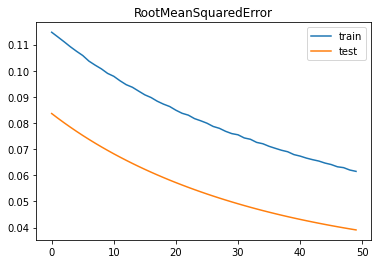

In [56]:
plt.title('RootMeanSquaredError')
plt.plot(hist10.history['root_mean_squared_error'], label='train')
plt.plot(hist10.history['val_root_mean_squared_error'], label='test')
plt.legend()
plt.show();